# feature selection

## column classification & setup

In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### import data

In [3]:
# get data
df = pd.read_parquet("../data/01_training.parquet")

df = df.drop([
    # uneeded identifiers
    'media_title',
    'tmdb_id',
    'media_type',
    # tv metadata, not used currently
    'season',
    'episode',
    # db record timestamps
    'created_at',
    'updated_at'
], axis=1)

df.rename(columns={'imdb_id': 'id'}, inplace=True)

display(df.head())

,id,label,release_year,budget,revenue,runtime,origin_country,production_companies,production_countries,production_status,...,genre,original_media_title,tagline,overview,tmdb_rating,tmdb_votes,rt_score,metascore,imdb_rating,imdb_votes
0,tt0048545,would_watch,1955,1500000.0,4500000.0,111.0,[US],[Warner Bros. Pictures],[US],Released,...,[Drama],Rebel Without a Cause,The bad boy from a good family.,"After moving to a new town, troublemaking teen...",7.515,1655,93.0,89.0,7.6,100836.0
1,tt0049261,would_watch,1956,5400000.0,32855818.0,201.0,[US],"[Warner Bros. Pictures, George Stevens Jr. Pro...",[US],Released,...,"[Drama, Western]",Giant,Sometimes any man can be a giant . . .,Wealthy rancher Bick Benedict and dirt-poor co...,7.600,708,86.0,84.0,7.6,43347.0
2,tt0049586,would_not_watch,1956,0.0,0.0,81.0,[US],[Universal International Pictures],[US],Released,...,"[Crime, Drama, Thriller]",Outside the Law,T-Men blast counterfeiting racket!,A government agent's son wins respect and love...,5.700,11,NaN,NaN,6.3,193.0
3,tt0049730,would_watch,1956,3750000.0,0.0,119.0,[US],"[C.V. Whitney Pictures, Warner Bros. Pictures]",[US],Released,...,[Western],The Searchers,He had to find her... he had to find her...,As a Civil War veteran spends years searching ...,7.700,1459,87.0,94.0,7.8,99240.0
4,tt0049745,would_not_watch,1956,0.0,0.0,75.0,[US],[Columbia Pictures],[US],Released,...,[Western],7th Cavalry,CHARGING THE BATTLE LINES OF THE SIOUX AND THE...,An officer accused of cowardice volunteers to ...,5.700,17,NaN,NaN,5.8,1413.0


### format data

In [4]:
# Separate features from target and identifier
id_col = 'id'
target_col = 'label'
features = df.drop(columns=[target_col, id_col])
target = df[target_col]
identifier = df[id_col]

# Determine target type
target_type = 'categorical' if target.dtype == 'object' or target.nunique() < 10 else 'continuous'

# Classify feature columns
numeric_cols = []
categorical_cols = []
text_cols = []
categorical_list_cols = []

for col in features.columns:
    if features[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)
    elif features[col].dtype == 'object':
        # Check if it's a list format (starts with '[' and ends with ']')
        sample_val = str(features[col].iloc[0])
        if sample_val.startswith('[') and sample_val.endswith(']'):
            categorical_list_cols.append(col)
        else:
            # Distinguish between categorical and text
            avg_length = features[col].astype(str).str.len().mean()
            unique_ratio = features[col].nunique() / len(features)
            
            if avg_length > 50 or unique_ratio > 0.8:
                text_cols.append(col)
            else:
                categorical_cols.append(col)
    else:
        # Handle datetime, bool, etc.
        categorical_cols.append(col)

print(f"Target variable: {target_col} ({target_type})")
print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Text columns ({len(text_cols)}): {text_cols}")
print(f"Categorical list columns ({len(categorical_list_cols)}): {categorical_list_cols}")

# Create subsets for analysis
numeric_data = features[numeric_cols] if numeric_cols else pd.DataFrame()
categorical_data = features[categorical_cols] if categorical_cols else pd.DataFrame()
text_data = features[text_cols] if text_cols else pd.DataFrame()
categorical_list_data = features[categorical_list_cols] if categorical_list_cols else pd.DataFrame()

Target variable: label (categorical)
Numeric columns (9): ['budget', 'revenue', 'runtime', 'tmdb_rating', 'tmdb_votes', 'rt_score', 'metascore', 'imdb_rating', 'imdb_votes']
Categorical columns (4): ['release_year', 'production_status', 'original_language', 'tagline']
Text columns (2): ['original_media_title', 'overview']
Categorical list columns (5): ['origin_country', 'production_companies', 'production_countries', 'spoken_languages', 'genre']


## data quality anaylsis

### null analysis

In [5]:
# Calculate nulls and null percentages
null_counts = features.isnull().sum().reset_index()
null_counts.columns = ['column', 'null_count']
null_counts['null_percentage'] = (null_counts['null_count'] / len(df)) * 100

# Add column type
def get_column_type(col):
    if col in numeric_cols:
        return 'numeric'
    elif col in categorical_cols:
        return 'categorical'
    elif col in text_cols:
        return 'text'
    elif col in categorical_list_cols:
        return 'categorical_list'
    else:
        return 'unknown'

null_counts['column_type'] = null_counts['column'].apply(get_column_type)
null_counts = null_counts.sort_values('null_percentage', ascending=True)

# Stylized output
styled_nulls = (null_counts
    .style
    .background_gradient(subset=['null_percentage'], cmap='RdYlGn_r')
    .bar(subset=['null_percentage'], color='#4a90e2', align='mid')
    .format({'null_percentage': '{:,.2f}%'})
    .set_caption('Feature Null Analysis')
)

display(styled_nulls)

,column,null_count,null_percentage,column_type
0,release_year,0,0.00%,categorical
7,production_status,0,0.00%,categorical
15,tmdb_votes,0,0.00%,numeric
14,tmdb_rating,0,0.00%,numeric
12,tagline,0,0.00%,categorical
13,overview,0,0.00%,text
11,original_media_title,0,0.00%,text
8,original_language,0,0.00%,categorical
4,origin_country,4,0.11%,categorical_list
1,budget,45,1.20%,numeric


### distinct anaylsis   

In [6]:
# Calculate distinct counts and percentages
# Handle categorical list columns by converting lists to strings
features_for_distinct = features.copy()
for col in categorical_list_cols:
    features_for_distinct[col] = features_for_distinct[col].astype(str)

distinct_counts = features_for_distinct.nunique().reset_index()
distinct_counts.columns = ['column', 'distinct_count']
distinct_counts['distinct_percentage'] = (distinct_counts['distinct_count'] / len(df)) * 100

# Add column type
def get_column_type(col):
    if col in numeric_cols:
        return 'numeric'
    elif col in categorical_cols:
        return 'categorical'
    elif col in text_cols:
        return 'text'
    elif col in categorical_list_cols:
        return 'categorical_list'
    else:
        return 'unknown'

distinct_counts['column_type'] = distinct_counts['column'].apply(get_column_type)
distinct_counts = distinct_counts.sort_values('distinct_percentage', ascending=True)

# Stylized output
styled_distinct = (distinct_counts
    .style
    .background_gradient(subset=['distinct_percentage'], cmap='RdYlGn_r')
    .bar(subset=['distinct_percentage'], color='#4a90e2', align='mid')
    .format({'distinct_percentage': '{:,.2f}%'})
    .set_caption('Feature Distinct Value Analysis')
)

display(styled_distinct)

,column,distinct_count,distinct_percentage,column_type
7,production_status,5,0.13%,categorical
8,original_language,59,1.57%,categorical
18,imdb_rating,80,2.13%,numeric
17,metascore,82,2.19%,numeric
16,rt_score,94,2.51%,numeric
0,release_year,105,2.80%,categorical
3,runtime,194,5.17%,numeric
4,origin_country,227,6.05%,categorical_list
1,budget,281,7.49%,numeric
9,spoken_languages,377,10.05%,categorical_list


## statistical and visual anaylsis by type

### numeric types

=== NUMERIC FEATURES ANALYSIS (9 columns) ===

--- budget ---


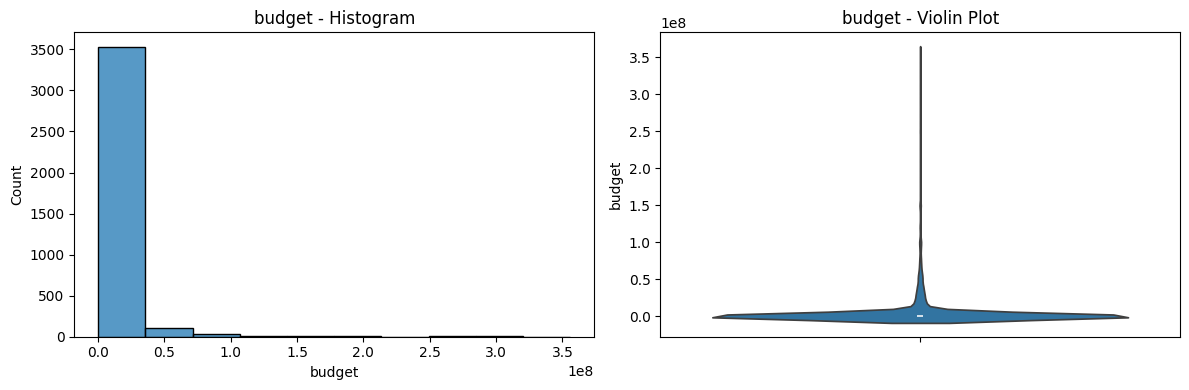

,Metric,Value
0,Original Shapiro Stat,0.2501
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.8605
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,Yes


--------------------------------------------------

--- revenue ---


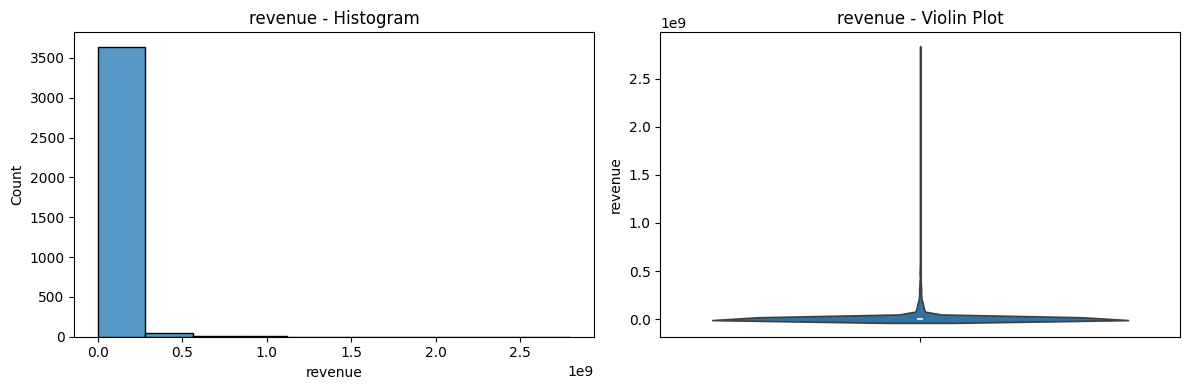

,Metric,Value
0,Original Shapiro Stat,0.1655
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.9293
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,Yes


--------------------------------------------------

--- runtime ---


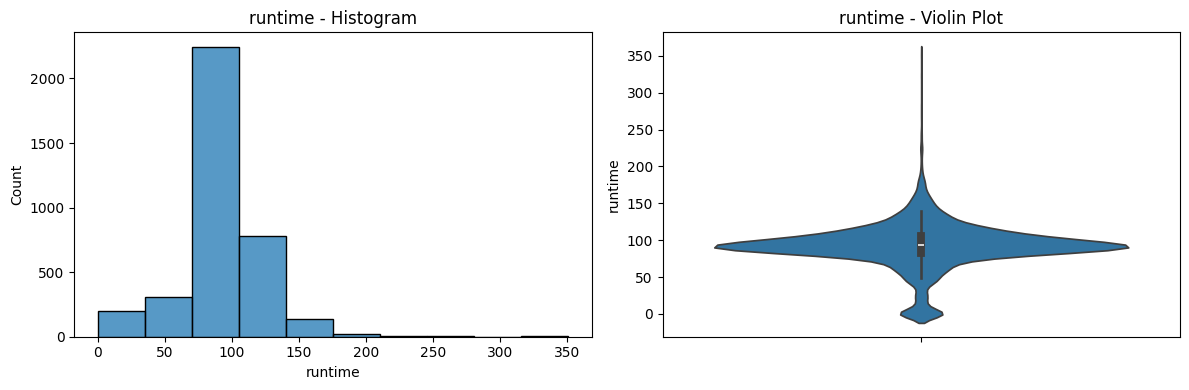

,Metric,Value
0,Original Shapiro Stat,0.8927
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.7382
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,No


--------------------------------------------------

--- tmdb_rating ---


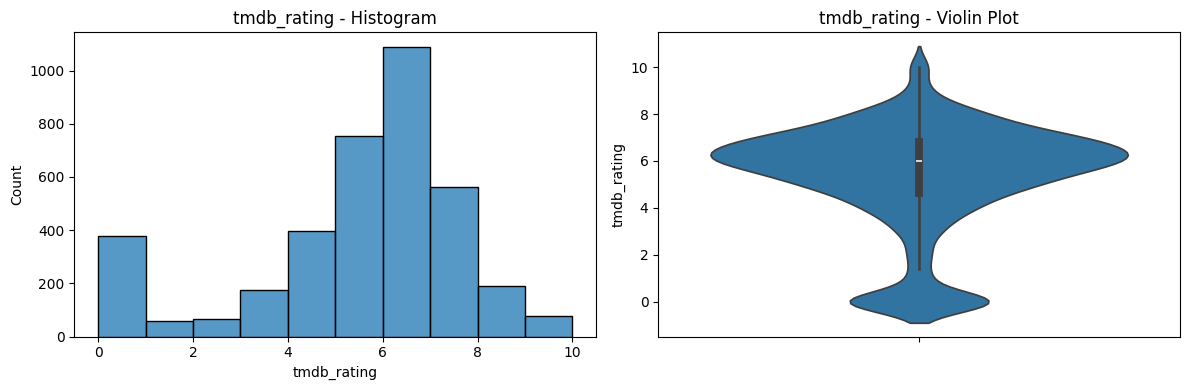

,Metric,Value
0,Original Shapiro Stat,0.8781
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.7959
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,No


--------------------------------------------------

--- tmdb_votes ---


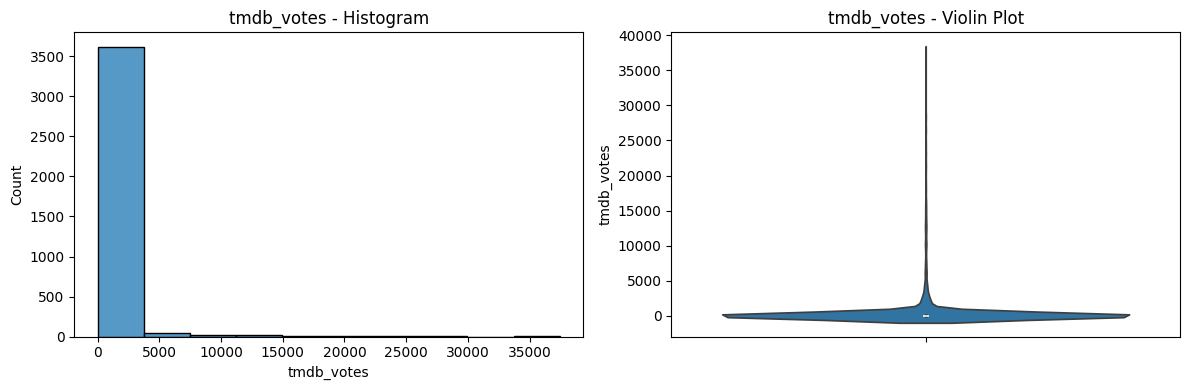

,Metric,Value
0,Original Shapiro Stat,0.2147
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.9278
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,Yes


--------------------------------------------------

--- rt_score ---


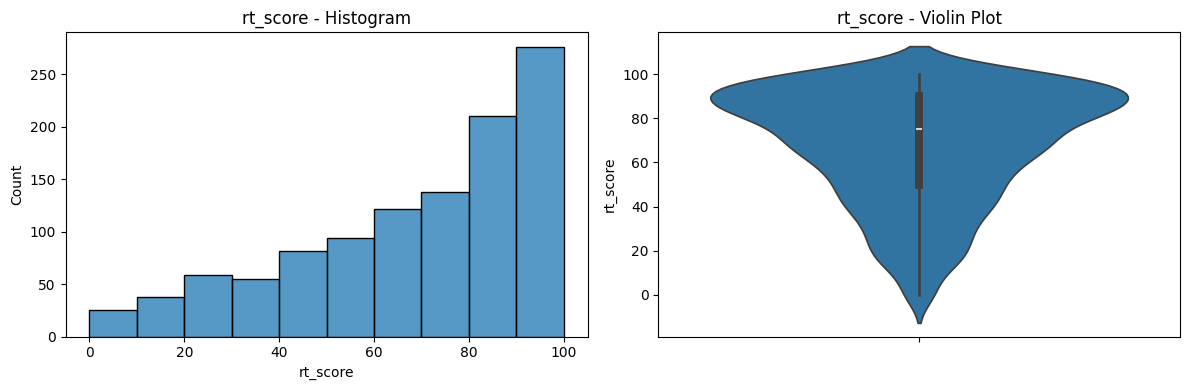

,Metric,Value
0,Original Shapiro Stat,0.9195
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.7982
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,No


--------------------------------------------------

--- metascore ---


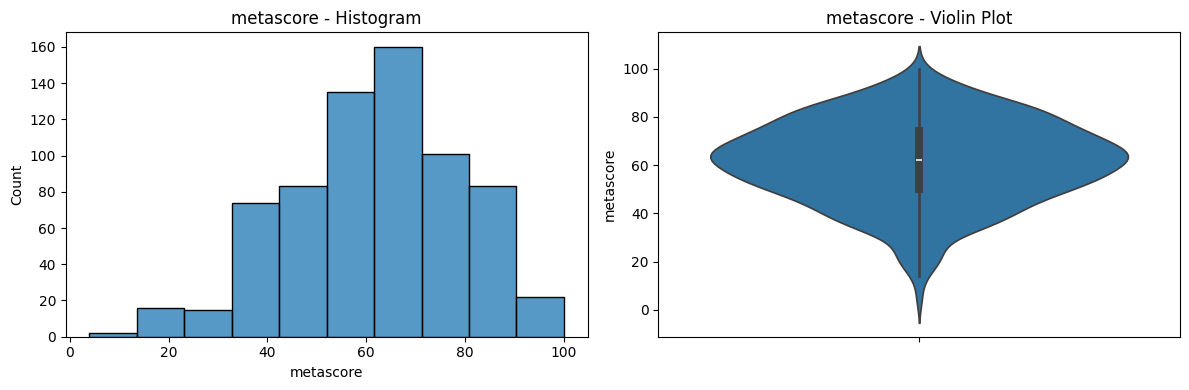

,Metric,Value
0,Original Shapiro Stat,0.9898
1,Original P-value,0.0001
2,Original Normal,No
3,Log Shapiro Stat,0.8681
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,No


--------------------------------------------------

--- imdb_rating ---


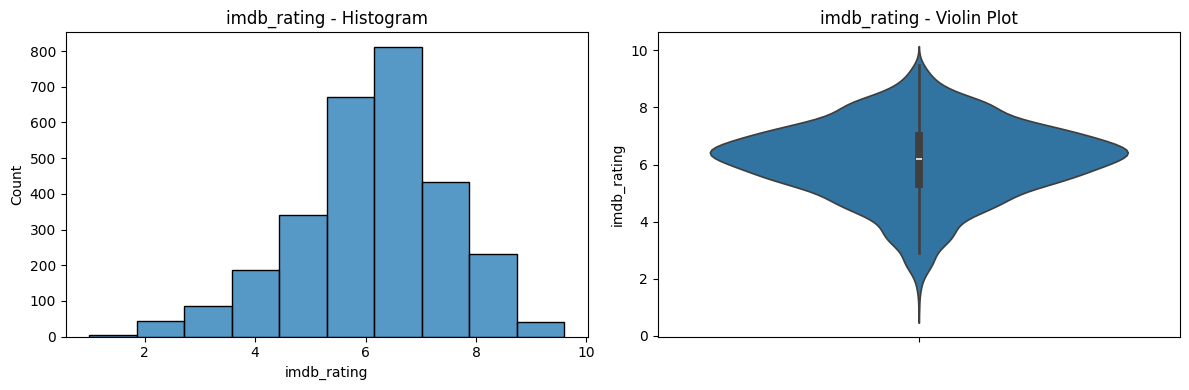

,Metric,Value
0,Original Shapiro Stat,0.9872
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.9131
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,No


--------------------------------------------------

--- imdb_votes ---


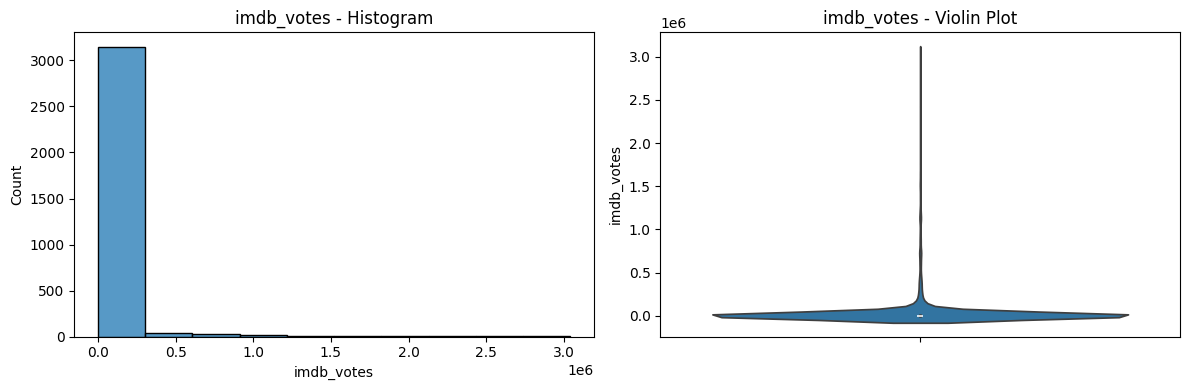

,Metric,Value
0,Original Shapiro Stat,0.2086
1,Original P-value,0.0000
2,Original Normal,No
3,Log Shapiro Stat,0.9589
4,Log P-value,0.0000
5,Log Normal,No
6,Log Transform Recommended,Yes


--------------------------------------------------


In [7]:
# NUMERIC FEATURES ANALYSIS - Iterative
if len(numeric_cols) > 0:
    print(f"=== NUMERIC FEATURES ANALYSIS ({len(numeric_cols)} columns) ===")
    
    for col in numeric_cols:
        print(f"\n--- {col} ---")
        
        # Create subplot figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Histogram
        sns.histplot(data=numeric_data, x=col, bins=10, ax=ax1)
        ax1.set_title(f'{col} - Histogram')
        
        # Violin plot
        sns.violinplot(data=numeric_data, y=col, ax=ax2)
        ax2.set_title(f'{col} - Violin Plot')
        
        plt.tight_layout()
        plt.show()
        
        # Normality test
        data_clean = numeric_data[col].dropna()
        if len(data_clean) > 3:
            # Original data test
            stat, p_value = stats.shapiro(data_clean[:5000])
            
            # Log transform test (only on positive values)
            log_stat, log_p_value = None, None
            positive_data = data_clean[data_clean > 0]
            if len(positive_data) > 3:
                log_data = np.log(positive_data[:5000])
                log_stat, log_p_value = stats.shapiro(log_data)
            
            # Create results table
            metrics = ['Original Shapiro Stat', 'Original P-value', 'Original Normal', 
                      'Log Shapiro Stat', 'Log P-value', 'Log Normal', 'Log Transform Recommended']
            values = [
                f'{stat:.4f}', 
                f'{p_value:.4f}', 
                'Yes' if p_value > 0.05 else 'No',
                f'{log_stat:.4f}' if log_stat else 'N/A',
                f'{log_p_value:.4f}' if log_p_value else 'N/A',
                'Yes' if log_p_value and log_p_value > 0.05 else 'No' if log_p_value else 'N/A',
                'Yes' if log_p_value and log_p_value > p_value else 'No' if log_p_value else 'N/A'
            ]
            
            result_df = pd.DataFrame({'Metric': metrics, 'Value': values})
            
            styled_result = (result_df
                .style
                .apply(lambda x: ['background-color: lightgreen' if 'Yes' in str(v) 
                                 else 'background-color: lightcoral' if 'No' in str(v) 
                                 else '' for v in x] if x.name == 'Value' else [''] * len(x), axis=0)
                .set_caption(f'{col} - Normality & Log Transform Analysis')
            )
            display(styled_result)
        else:
            print(f"Insufficient data for normality test (n={len(data_clean)})")
        
        print("-" * 50)

### categorical anaylsis

=== CATEGORICAL FEATURES ANALYSIS (4 columns) ===

--- release_year ---


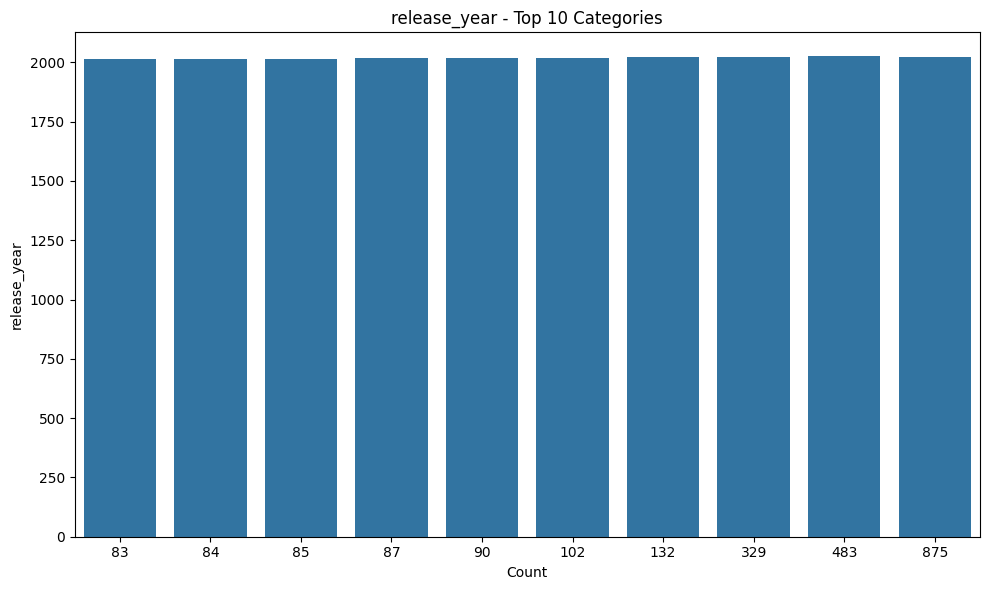

,Metric,Value
0,Total Categories,105
1,Top 10 Categories Shown,10
2,Most Frequent Category,2024
3,Most Frequent Count,875
4,Top 5 Categories %,51.2%
5,Categories with 1 Occurrence,6
6,Useful for ML,Review


--------------------------------------------------

--- production_status ---


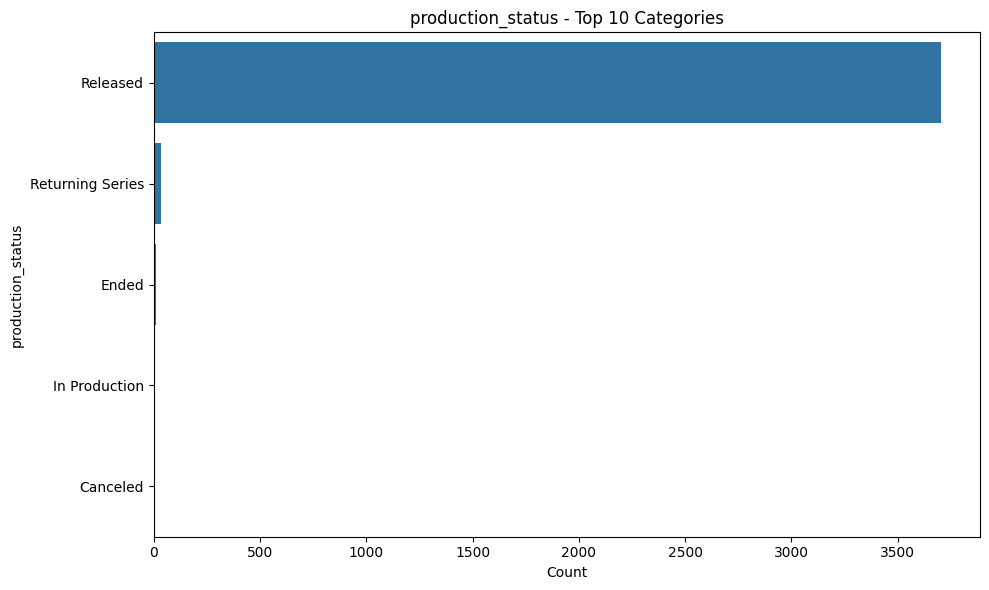

,Metric,Value
0,Total Categories,5
1,Top 10 Categories Shown,5
2,Most Frequent Category,Released
3,Most Frequent Count,3703
4,Top 5 Categories %,100.0%
5,Categories with 1 Occurrence,0
6,Useful for ML,Yes


--------------------------------------------------

--- original_language ---


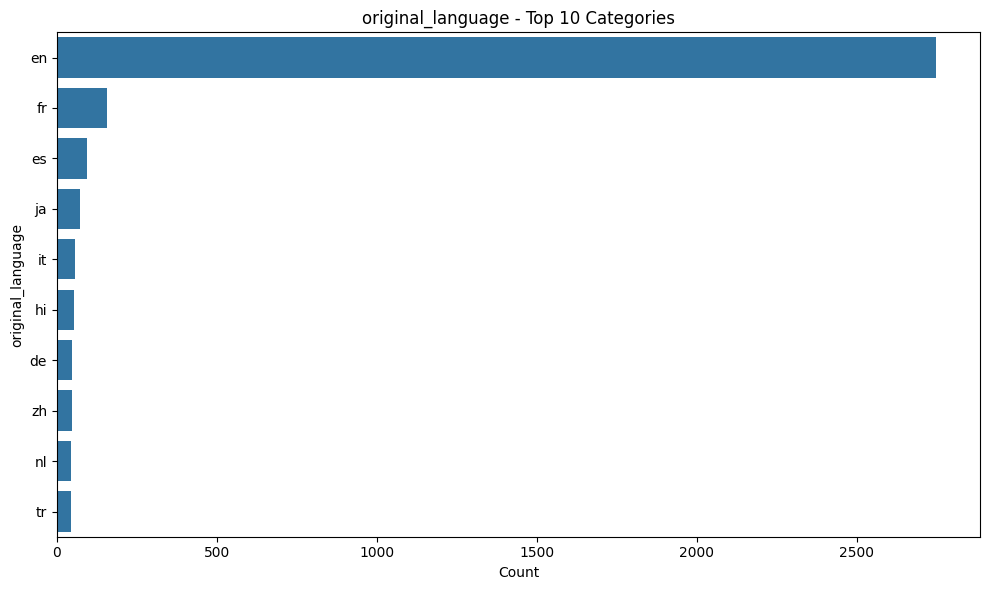

,Metric,Value
0,Total Categories,59
1,Top 10 Categories Shown,10
2,Most Frequent Category,en
3,Most Frequent Count,2748
4,Top 5 Categories %,83.5%
5,Categories with 1 Occurrence,9
6,Useful for ML,Yes


--------------------------------------------------

--- tagline ---


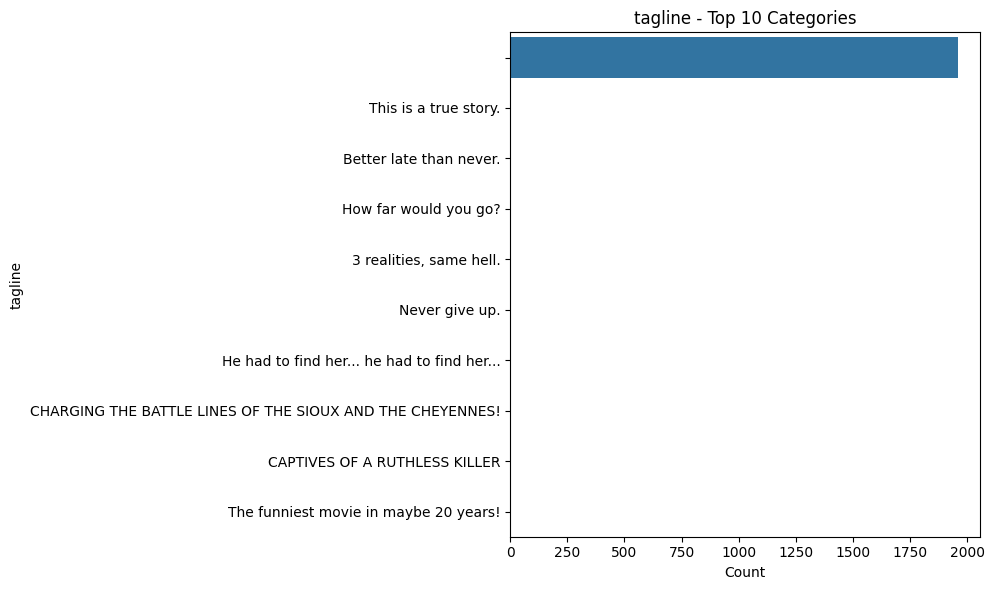

,Metric,Value
0,Total Categories,1789
1,Top 10 Categories Shown,10
2,Most Frequent Category,
3,Most Frequent Count,1957
4,Top 5 Categories %,52.4%
5,Categories with 1 Occurrence,1783
6,Useful for ML,Review


--------------------------------------------------


In [8]:
# CATEGORICAL FEATURES ANALYSIS - Iterative
if len(categorical_cols) > 0:
    print(f"=== CATEGORICAL FEATURES ANALYSIS ({len(categorical_cols)} columns) ===")
    
    for col in categorical_cols:
        print(f"\n--- {col} ---")
        
        # Get value counts
        value_counts = categorical_data[col].value_counts()
        top_10 = value_counts.head(10)
        
        # Create bar chart
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_10.values, y=top_10.index)
        plt.title(f'{col} - Top 10 Categories')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.show()
        
        # Category analysis table
        total_categories = len(value_counts)
        top_5_pct = (top_10.head(5).sum() / categorical_data[col].count()) * 100
        
        analysis_df = pd.DataFrame({
            'Metric': [
                'Total Categories',
                'Top 10 Categories Shown',
                'Most Frequent Category',
                'Most Frequent Count',
                'Top 5 Categories %',
                'Categories with 1 Occurrence',
                'Useful for ML'
            ],
            'Value': [
                str(total_categories),
                str(min(10, total_categories)),
                str(value_counts.index[0]),
                str(value_counts.iloc[0]),
                f'{top_5_pct:.1f}%',
                str((value_counts == 1).sum()),
                'Yes' if total_categories > 1 and total_categories < 100 else 'Review'
            ]
        })
        
        styled_analysis = (analysis_df
            .style
            .apply(lambda x: ['background-color: lightgreen' if 'Yes' in str(v) 
                             else 'background-color: lightyellow' if 'Review' in str(v)
                             else '' for v in x] if x.name == 'Value' else [''] * len(x), axis=0)
            .set_caption(f'{col} - Category Analysis')
        )
        display(styled_analysis)
        
        print("-" * 50)

### categorica lists

=== CATEGORICAL LIST FEATURES ANALYSIS (5 columns) ===

--- origin_country ---


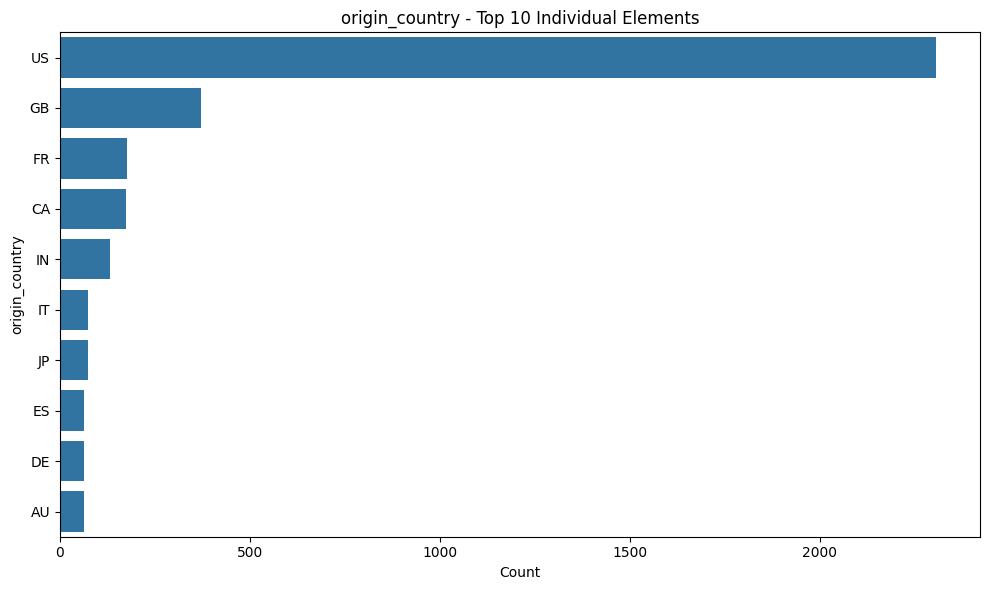

,Metric,Value
0,Unique Elements,93
1,Total Element Occurrences,4239
2,Most Frequent Element,US
3,Most Frequent Count,2307
4,Top 5 Elements %,74.6%
5,Elements with 1 Occurrence,20
6,Useful for ML,Yes


--------------------------------------------------

--- production_companies ---


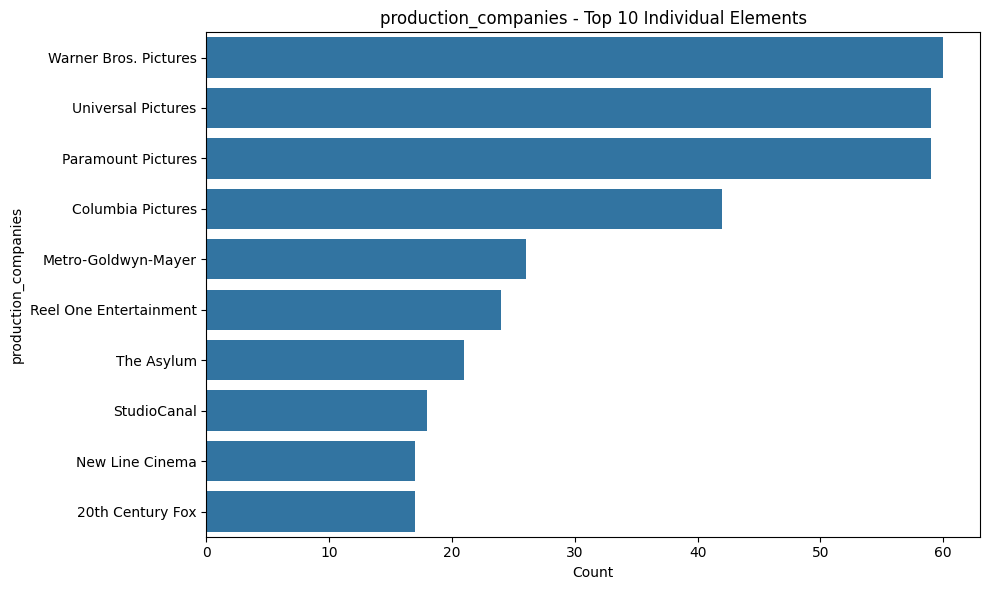

,Metric,Value
0,Unique Elements,5232
1,Total Element Occurrences,7600
2,Most Frequent Element,Warner Bros. Pictures
3,Most Frequent Count,60
4,Top 5 Elements %,3.2%
5,Elements with 1 Occurrence,4295
6,Useful for ML,Review


--------------------------------------------------

--- production_countries ---


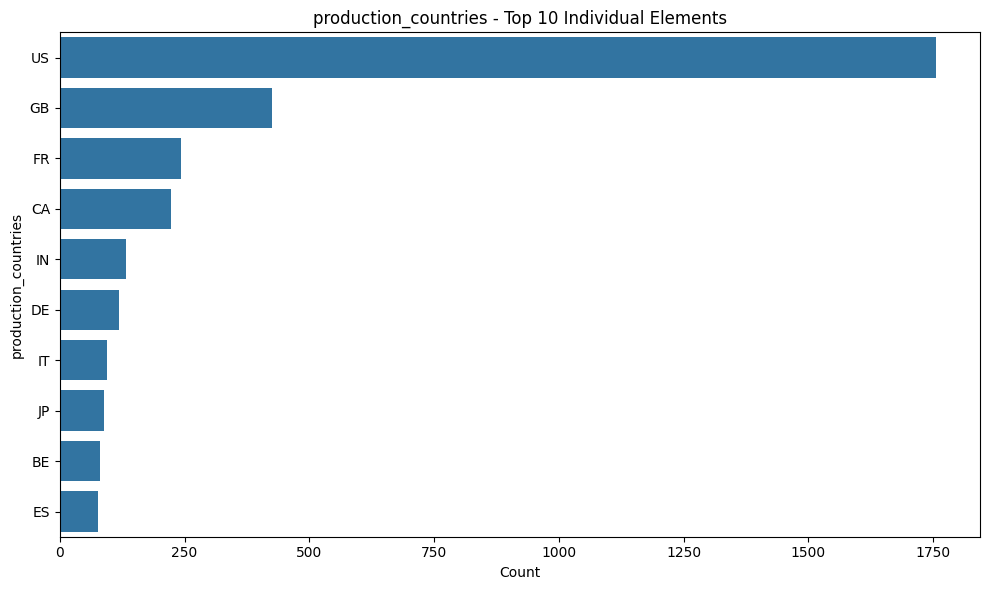

,Metric,Value
0,Unique Elements,111
1,Total Element Occurrences,4178
2,Most Frequent Element,US
3,Most Frequent Count,1756
4,Top 5 Elements %,66.5%
5,Elements with 1 Occurrence,31
6,Useful for ML,Yes


--------------------------------------------------

--- spoken_languages ---


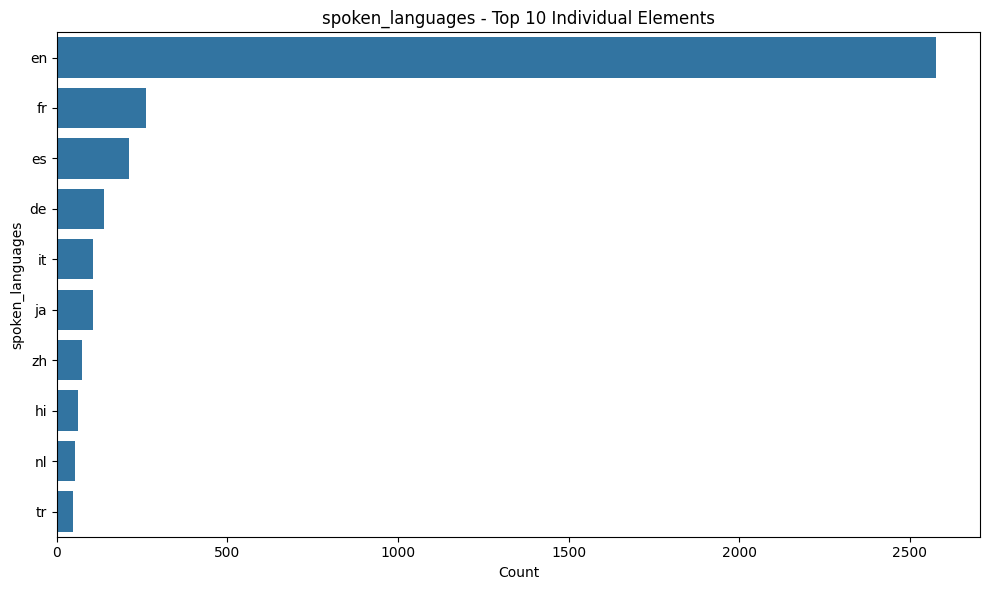

,Metric,Value
0,Unique Elements,94
1,Total Element Occurrences,4407
2,Most Frequent Element,en
3,Most Frequent Count,2577
4,Top 5 Elements %,74.7%
5,Elements with 1 Occurrence,26
6,Useful for ML,Yes


--------------------------------------------------

--- genre ---


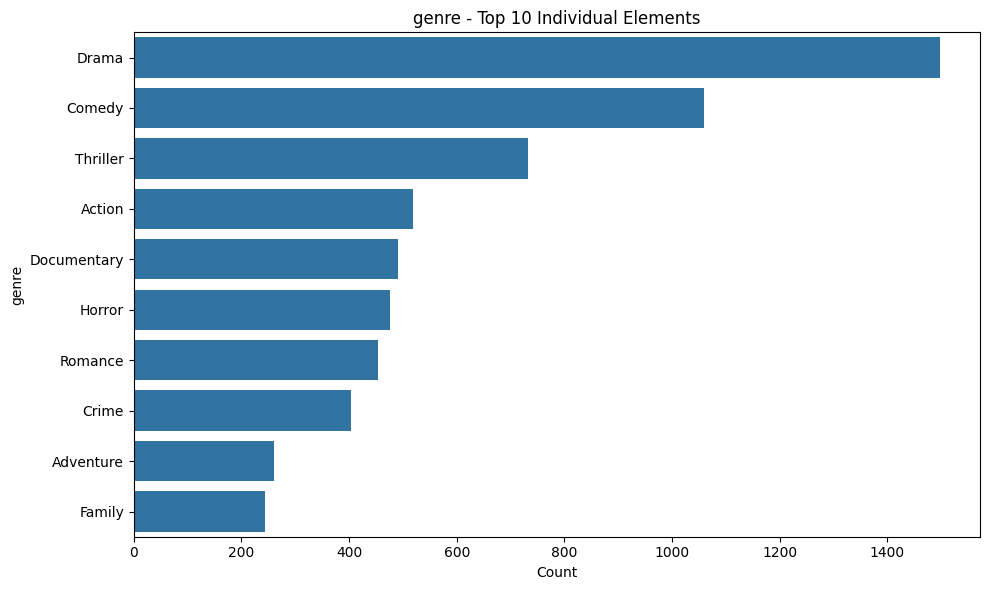

,Metric,Value
0,Unique Elements,25
1,Total Element Occurrences,7611
2,Most Frequent Element,Drama
3,Most Frequent Count,1497
4,Top 5 Elements %,56.5%
5,Elements with 1 Occurrence,1
6,Useful for ML,Yes


--------------------------------------------------


In [9]:
# CATEGORICAL LIST FEATURES ANALYSIS - Iterative
if len(categorical_list_cols) > 0:
    print(f"=== CATEGORICAL LIST FEATURES ANALYSIS ({len(categorical_list_cols)} columns) ===")
    
    for col in categorical_list_cols:
        print(f"\n--- {col} ---")
        
        # Extract all individual elements from lists
        all_elements = []
        for row in categorical_list_data[col].dropna():
            try:
                # Handle lists, numpy arrays, and string representations
                if isinstance(row, (list, np.ndarray)):
                    all_elements.extend(row)
                elif isinstance(row, str):
                    elements = eval(row)
                    if isinstance(elements, (list, np.ndarray)):
                        all_elements.extend(elements)
            except:
                continue
        
        # Count elements
        if not all_elements:
            print(f"No valid elements found in {col}")
            continue
            
        element_counts = pd.Series(all_elements).value_counts()
        top_10 = element_counts.head(10)
        
        # Create bar chart
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_10.values, y=top_10.index)
        plt.title(f'{col} - Top 10 Individual Elements')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
        
        # Element analysis table
        total_elements = len(element_counts)
        total_occurrences = sum(element_counts)
        top_5_pct = (top_10.head(5).sum() / total_occurrences) * 100
        
        analysis_df = pd.DataFrame({
            'Metric': [
                'Unique Elements',
                'Total Element Occurrences',
                'Most Frequent Element',
                'Most Frequent Count',
                'Top 5 Elements %',
                'Elements with 1 Occurrence',
                'Useful for ML'
            ],
            'Value': [
                str(total_elements),
                str(total_occurrences),
                str(element_counts.index[0]),
                str(element_counts.iloc[0]),
                f'{top_5_pct:.1f}%',
                str((element_counts == 1).sum()),
                'Yes' if total_elements > 1 and total_elements < 1000 else 'Review'
            ]
        })
        
        styled_analysis = (analysis_df
            .style
            .apply(lambda x: ['background-color: lightgreen' if 'Yes' in str(v) 
                             else 'background-color: lightyellow' if 'Review' in str(v)
                             else '' for v in x] if x.name == 'Value' else [''] * len(x), axis=0)
            .set_caption(f'{col} - Element Analysis')
        )
        display(styled_analysis)
        
        print("-" * 50)

### strings

=== TEXT FEATURES ANALYSIS (2 columns) ===

--- original_media_title ---


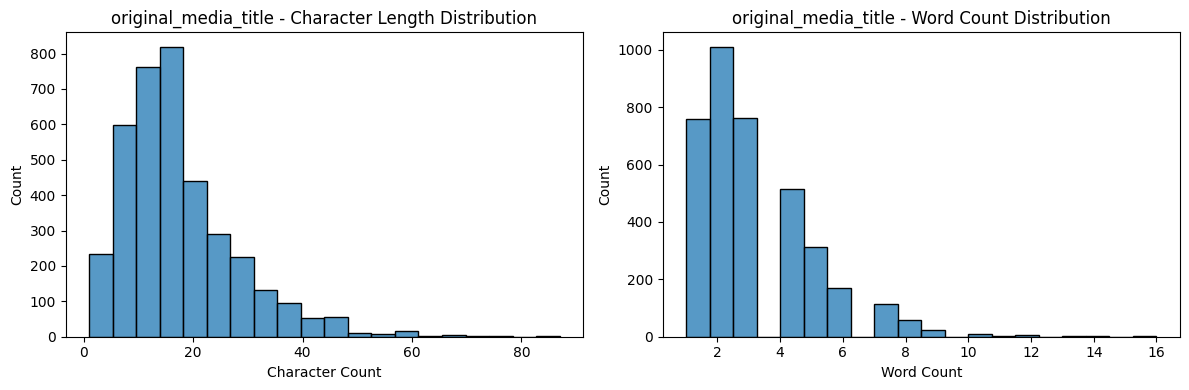

,Metric,Value
0,Avg Character Length,17.4
1,Median Character Length,15.0
2,Max Character Length,87
3,Avg Word Count,3.1
4,Median Word Count,3.0
5,Distinct Values,3738
6,Distinct Ratio,0.997
7,Embedding Candidate,No


--------------------------------------------------

--- overview ---


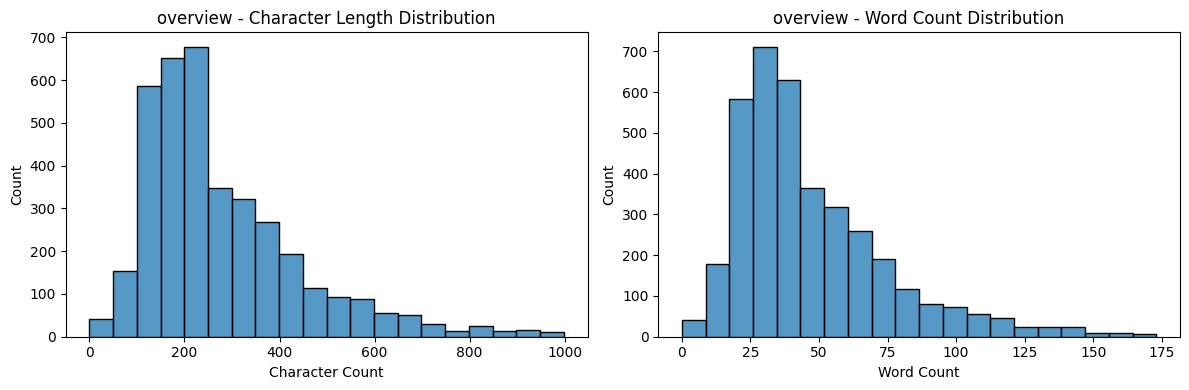

,Metric,Value
0,Avg Character Length,278.3
1,Median Character Length,231.5
2,Max Character Length,998
3,Avg Word Count,47.1
4,Median Word Count,39.0
5,Distinct Values,3724
6,Distinct Ratio,0.993
7,Embedding Candidate,Yes


--------------------------------------------------


In [10]:
# TEXT FEATURES ANALYSIS - Iterative
if len(text_cols) > 0:
    print(f"=== TEXT FEATURES ANALYSIS ({len(text_cols)} columns) ===")
    
    for col in text_cols:
        print(f"\n--- {col} ---")
        
        # Calculate text metrics
        text_lengths = text_data[col].astype(str).str.len()
        word_counts = text_data[col].astype(str).str.split().str.len()
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Character length distribution
        sns.histplot(text_lengths, bins=20, ax=ax1)
        ax1.set_title(f'{col} - Character Length Distribution')
        ax1.set_xlabel('Character Count')
        
        # Word count distribution  
        sns.histplot(word_counts, bins=20, ax=ax2)
        ax2.set_title(f'{col} - Word Count Distribution')
        ax2.set_xlabel('Word Count')
        
        plt.tight_layout()
        plt.show()
        
        # Text analysis table
        analysis_df = pd.DataFrame({
            'Metric': [
                'Avg Character Length',
                'Median Character Length',
                'Max Character Length',
                'Avg Word Count',
                'Median Word Count',
                'Distinct Values',
                'Distinct Ratio',
                'Embedding Candidate'
            ],
            'Value': [
                f'{text_lengths.mean():.1f}',
                f'{text_lengths.median():.1f}',
                f'{text_lengths.max()}',
                f'{word_counts.mean():.1f}',
                f'{word_counts.median():.1f}',
                f'{text_data[col].nunique()}',
                f'{text_data[col].nunique() / len(text_data):.3f}',
                'Yes' if text_lengths.mean() > 20 and text_data[col].nunique() / len(text_data) > 0.5 else 'No'
            ]
        })
        
        styled_analysis = (analysis_df
            .style
            .apply(lambda x: ['background-color: lightgreen' if 'Yes' in str(v) 
                             else 'background-color: lightcoral' if 'No' in str(v)
                             else '' for v in x] if x.name == 'Value' else [''] * len(x), axis=0)
            .set_caption(f'{col} - Text Analysis')
        )
        display(styled_analysis)
        
        print("-" * 50)

## inter-feature anaylsis

### numerics

=== NUMERIC INTER-FEATURE ANALYSIS (9 columns) ===


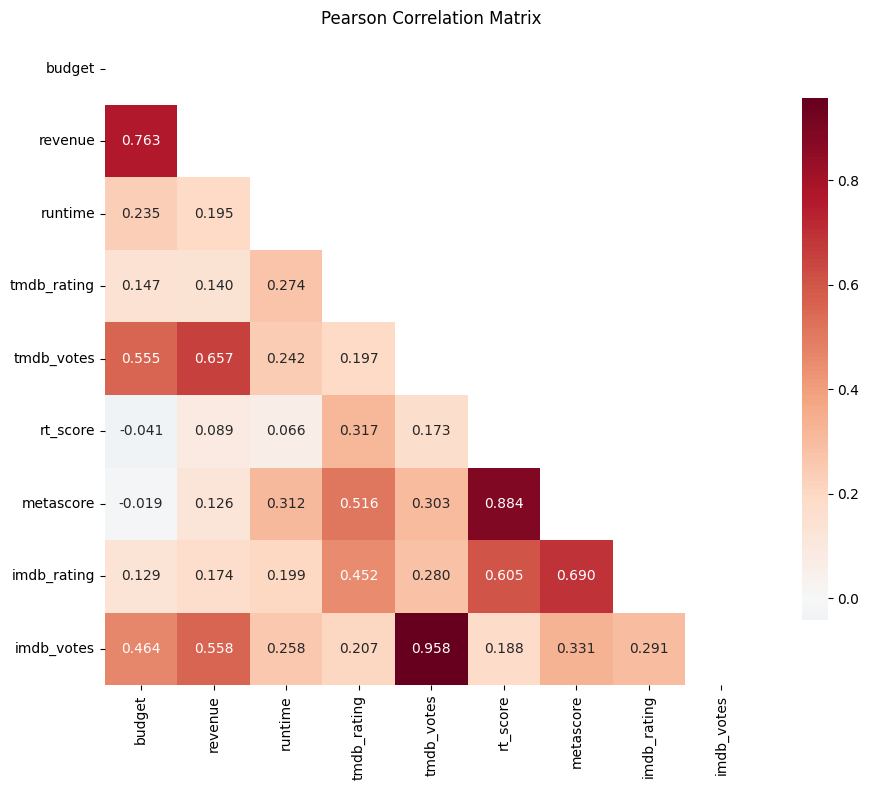

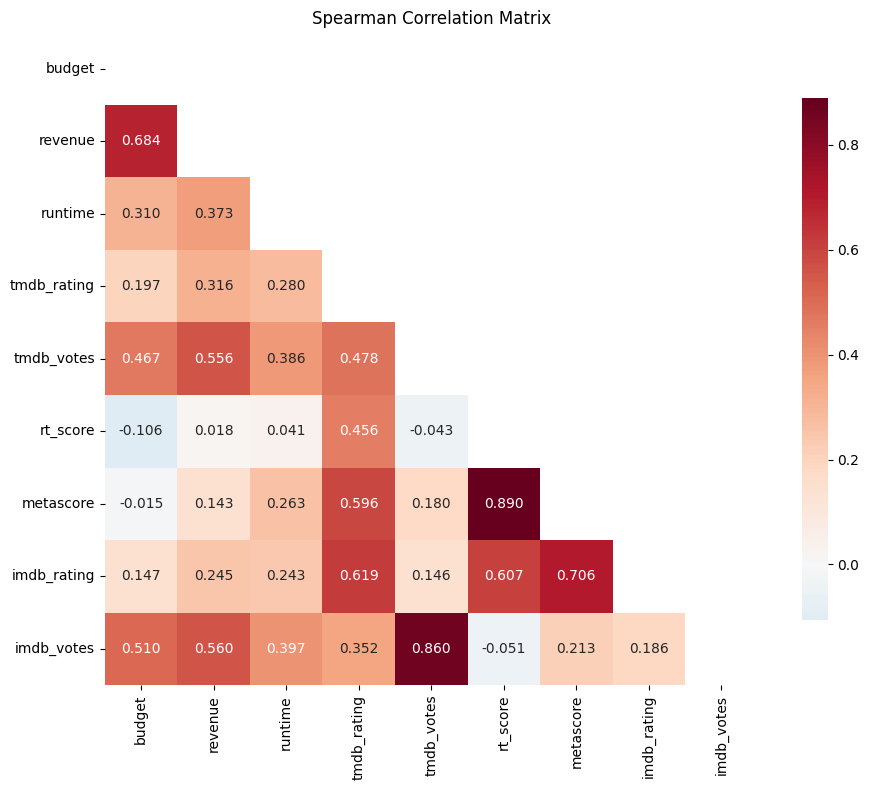

,Feature 1,Feature 2,Pearson |r|,Spearman |r|,Drop Candidate
0,tmdb_votes,imdb_votes,0.958,0.860,Yes
1,rt_score,metascore,0.884,0.890,Yes


In [11]:
# NUMERIC INTER-FEATURE ANALYSIS
if len(numeric_cols) > 1:
    print(f"=== NUMERIC INTER-FEATURE ANALYSIS ({len(numeric_cols)} columns) ===")
    
    # Pearson correlation matrix
    pearson_corr = numeric_data.corr(method='pearson')
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
    sns.heatmap(pearson_corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title('Pearson Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Spearman correlation matrix
    spearman_corr = numeric_data.corr(method='spearman')
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
    sns.heatmap(spearman_corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title('Spearman Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # High correlation pairs (threshold = 0.85 as per flowchart)
    threshold = 0.85
    high_corr_pairs = []
    
    for i in range(len(pearson_corr.columns)):
        for j in range(i+1, len(pearson_corr.columns)):
            col1, col2 = pearson_corr.columns[i], pearson_corr.columns[j]
            pearson_val = abs(pearson_corr.iloc[i, j])
            spearman_val = abs(spearman_corr.iloc[i, j])
            
            if pearson_val > threshold or spearman_val > threshold:
                high_corr_pairs.append({
                    'Feature 1': col1,
                    'Feature 2': col2,
                    'Pearson |r|': pearson_val,
                    'Spearman |r|': spearman_val,
                    'Drop Candidate': 'Yes'
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        styled_corr = (high_corr_df
            .style
            .background_gradient(subset=['Pearson |r|', 'Spearman |r|'], cmap='Reds')
            .apply(lambda x: ['background-color: lightcoral' if v == 'Yes' else '' 
                             for v in x] if x.name == 'Drop Candidate' else [''] * len(x), axis=0)
            .format({'Pearson |r|': '{:.3f}', 'Spearman |r|': '{:.3f}'})
            .set_caption(f'High Correlation Pairs (threshold = {threshold})')
        )
        display(styled_corr)
    else:
        print(f"No high correlation pairs found (threshold = {threshold})")
else:
    print("Need at least 2 numeric columns for correlation analysis")

### categoricals

=== CATEGORICAL INTER-FEATURE ANALYSIS (4 columns) ===


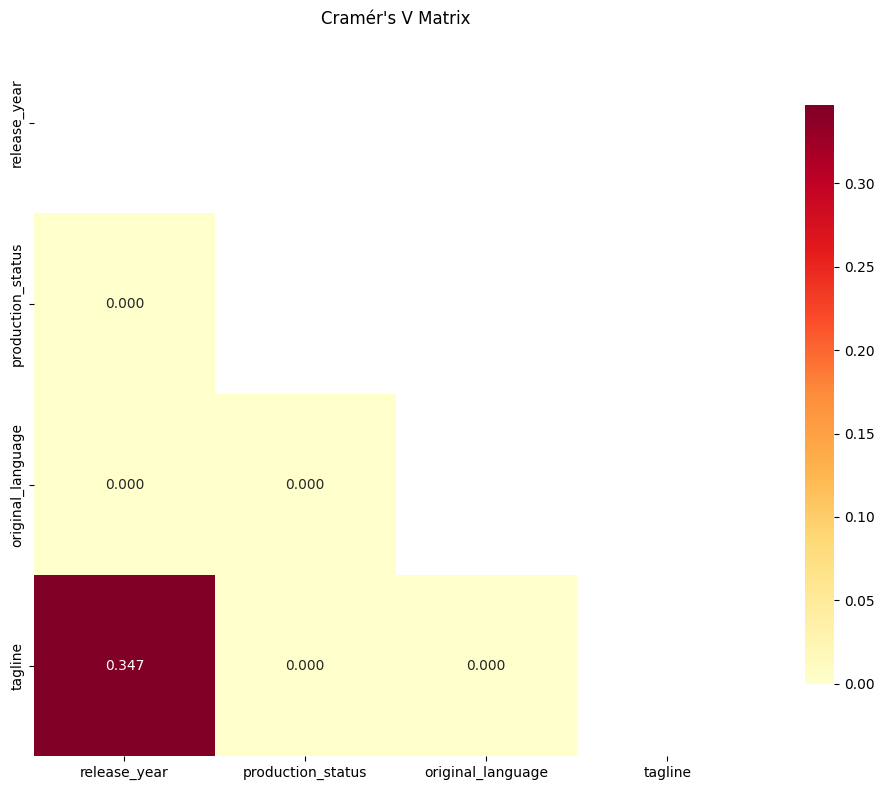

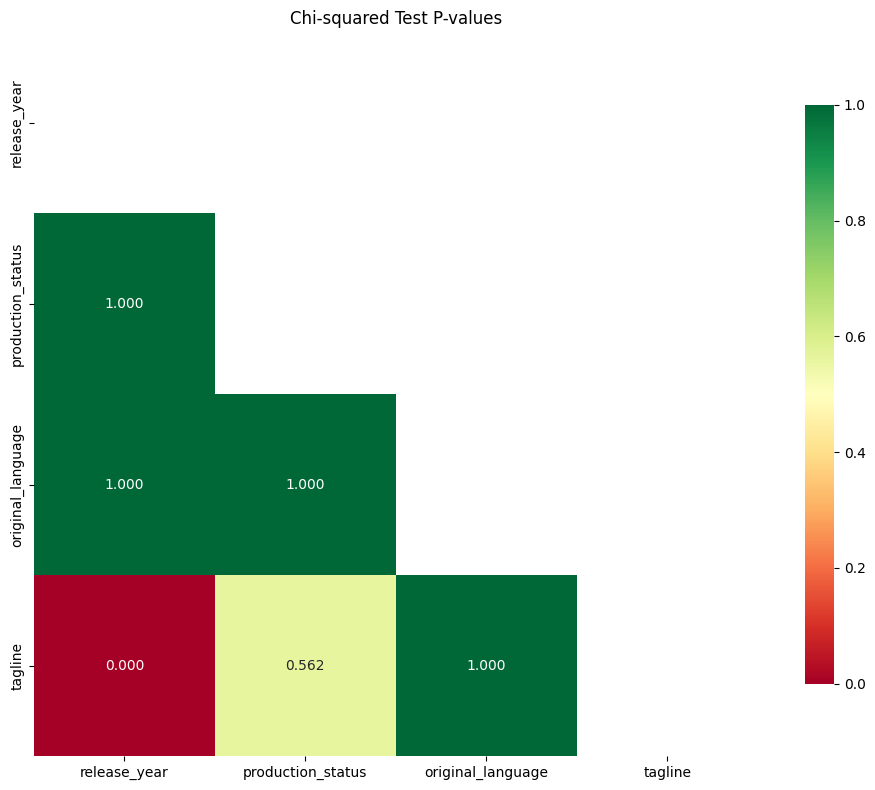

,Feature 1,Feature 2,Cramér's V,Chi2 p-value,Drop Candidate
0,release_year,tagline,0.347,0.000,Review


In [12]:
# CATEGORICAL INTER-FEATURE ANALYSIS
if len(categorical_cols) > 1:
    print(f"=== CATEGORICAL INTER-FEATURE ANALYSIS ({len(categorical_cols)} columns) ===")
    
    from scipy.stats import chi2_contingency
    
    # Cramér's V function
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2/n
        r,k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    
    # Calculate Cramér's V matrix
    cramers_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    chi2_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cramers_matrix.loc[col1, col2] = 1.0
                chi2_matrix.loc[col1, col2] = 1.0
            else:
                # Drop nulls for analysis
                data1 = categorical_data[col1].dropna()
                data2 = categorical_data[col2].dropna()
                common_idx = data1.index.intersection(data2.index)
                
                if len(common_idx) > 1:
                    cramers_v_val = cramers_v(data1[common_idx], data2[common_idx])
                    _, p_val, _, _ = chi2_contingency(pd.crosstab(data1[common_idx], data2[common_idx]))
                    
                    cramers_matrix.loc[col1, col2] = cramers_v_val
                    chi2_matrix.loc[col1, col2] = p_val
                else:
                    cramers_matrix.loc[col1, col2] = 0
                    chi2_matrix.loc[col1, col2] = 1
    
    # Convert to numeric
    cramers_matrix = cramers_matrix.astype(float)
    chi2_matrix = chi2_matrix.astype(float)
    
    # Cramér's V heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))
    sns.heatmap(cramers_matrix, mask=mask, annot=True, cmap='YlOrRd', 
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title("Cramér's V Matrix")
    plt.tight_layout()
    plt.show()
    
    # Chi-squared p-values heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(chi2_matrix, dtype=bool))
    sns.heatmap(chi2_matrix, mask=mask, annot=True, cmap='RdYlGn', 
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title('Chi-squared Test P-values')
    plt.tight_layout()
    plt.show()
    
    # High association pairs
    cramers_threshold = 0.75
    chi2_threshold = 0.05
    high_assoc_pairs = []
    
    for i in range(len(categorical_cols)):
        for j in range(i+1, len(categorical_cols)):
            col1, col2 = categorical_cols[i], categorical_cols[j]
            cramers_val = cramers_matrix.iloc[i, j]
            chi2_p = chi2_matrix.iloc[i, j]
            
            if cramers_val > cramers_threshold or chi2_p < chi2_threshold:
                high_assoc_pairs.append({
                    'Feature 1': col1,
                    'Feature 2': col2,
                    "Cramér's V": cramers_val,
                    'Chi2 p-value': chi2_p,
                    'Drop Candidate': 'Yes' if cramers_val > cramers_threshold else 'Review'
                })
    
    if high_assoc_pairs:
        assoc_df = pd.DataFrame(high_assoc_pairs)
        styled_assoc = (assoc_df
            .style
            .background_gradient(subset=["Cramér's V"], cmap='Reds')
            .background_gradient(subset=['Chi2 p-value'], cmap='RdYlGn_r')
            .apply(lambda x: ['background-color: lightcoral' if v == 'Yes' 
                             else 'background-color: lightyellow' if v == 'Review'
                             else '' for v in x] if x.name == 'Drop Candidate' else [''] * len(x), axis=0)
            .format({"Cramér's V": '{:.3f}', 'Chi2 p-value': '{:.3f}'})
            .set_caption(f'High Association Pairs (Cramér\'s V > {cramers_threshold} or p < {chi2_threshold})')
        )
        display(styled_assoc)
    else:
        print(f"No high association pairs found")
else:
    print("Need at least 2 categorical columns for association analysis")

### categorical vs numeric

=== NUMERIC vs CATEGORICAL INTER-FEATURE ANALYSIS ===
Testing 9 numeric vs 4 categorical features


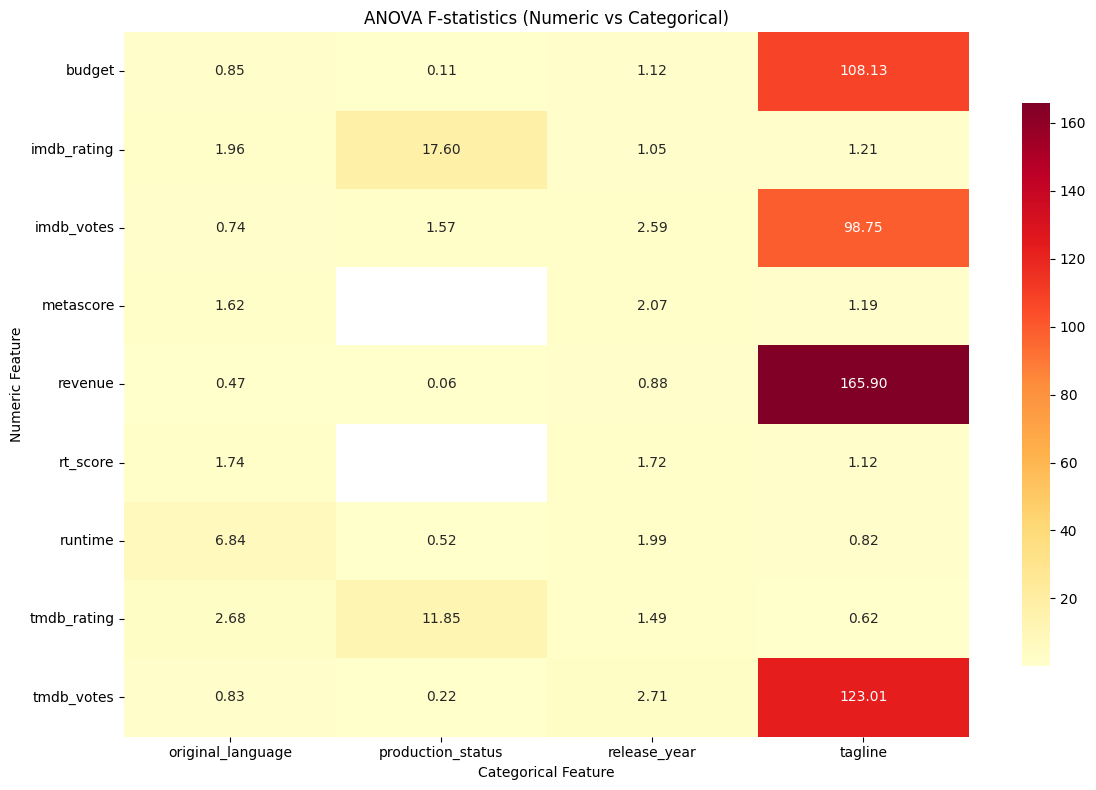

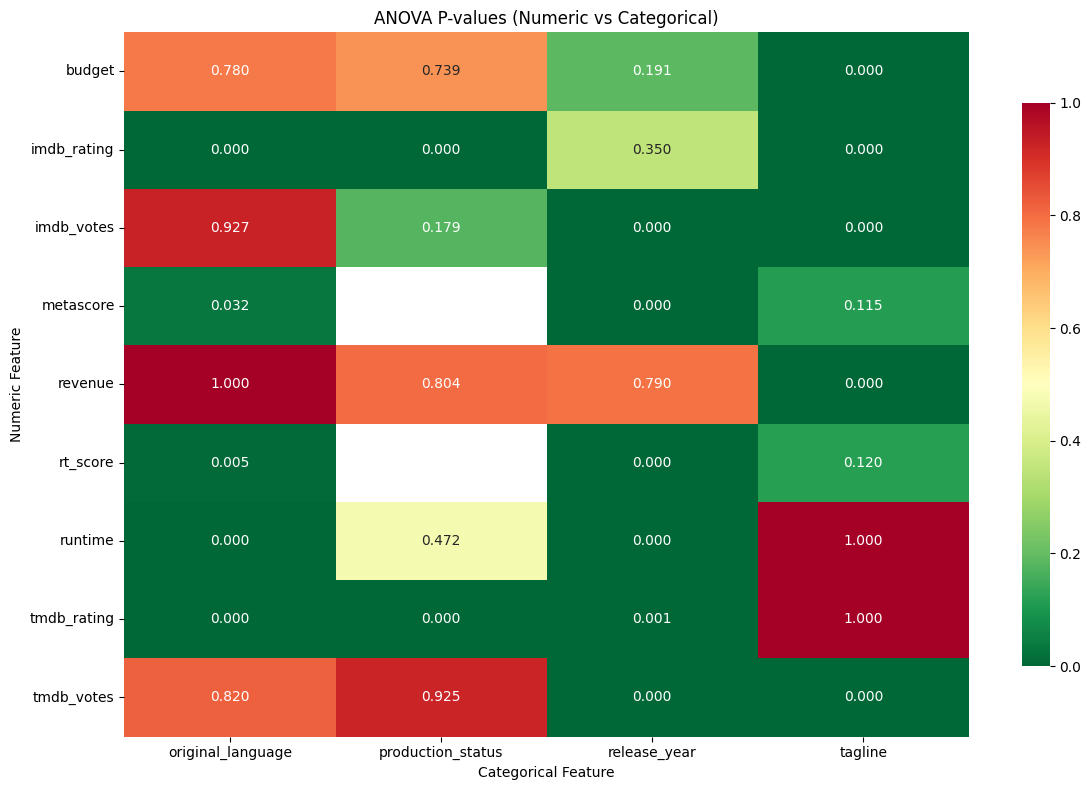

,Numeric Feature,Categorical Feature,F-statistic,P-value,Significant,Strong Association
7,revenue,tagline,165.90,0.0000,Yes,Yes
19,tmdb_votes,tagline,123.01,0.0000,Yes,Yes
3,budget,tagline,108.13,0.0000,Yes,Yes
33,imdb_votes,tagline,98.75,0.0000,Yes,Yes
27,imdb_rating,production_status,17.60,0.0000,Yes,Yes
13,tmdb_rating,production_status,11.85,0.0000,Yes,Yes
10,runtime,original_language,6.84,0.0000,Yes,No
16,tmdb_votes,release_year,2.71,0.0000,Yes,No
14,tmdb_rating,original_language,2.68,0.0000,Yes,No
30,imdb_votes,release_year,2.59,0.0000,Yes,No


In [13]:
# NUMERIC vs CATEGORICAL INTER-FEATURE ANALYSIS
if len(numeric_cols) > 0 and len(categorical_cols) > 0:
    print(f"=== NUMERIC vs CATEGORICAL INTER-FEATURE ANALYSIS ===")
    print(f"Testing {len(numeric_cols)} numeric vs {len(categorical_cols)} categorical features")
    
    from scipy.stats import f_oneway
    
    # ANOVA F-statistic matrix
    anova_results = []
    
    for num_col in numeric_cols:
        for cat_col in categorical_cols:
            # Get data without nulls
            combined_data = pd.DataFrame({
                'numeric': numeric_data[num_col],
                'categorical': categorical_data[cat_col]
            }).dropna()
            
            if len(combined_data) > 0:
                # Group numeric data by categorical
                groups = [group['numeric'].values for name, group in combined_data.groupby('categorical')]
                groups = [g for g in groups if len(g) > 0]  # Remove empty groups
                
                if len(groups) > 1:
                    f_stat, p_value = f_oneway(*groups)
                    
                    anova_results.append({
                        'Numeric Feature': num_col,
                        'Categorical Feature': cat_col,
                        'F-statistic': f_stat,
                        'P-value': p_value,
                        'Significant': 'Yes' if p_value < 0.05 else 'No',
                        'Strong Association': 'Yes' if f_stat > 10 else 'No'
                    })
    
    if anova_results:
        anova_df = pd.DataFrame(anova_results)
        
        # Create heatmap of F-statistics
        f_matrix = anova_df.pivot(index='Numeric Feature', 
                                  columns='Categorical Feature', 
                                  values='F-statistic')
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(f_matrix, annot=True, cmap='YlOrRd', fmt='.2f', 
                    cbar_kws={"shrink": .8})
        plt.title('ANOVA F-statistics (Numeric vs Categorical)')
        plt.tight_layout()
        plt.show()
        
        # Create heatmap of p-values
        p_matrix = anova_df.pivot(index='Numeric Feature', 
                                  columns='Categorical Feature', 
                                  values='P-value')
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(p_matrix, annot=True, cmap='RdYlGn_r', fmt='.3f', 
                    cbar_kws={"shrink": .8})
        plt.title('ANOVA P-values (Numeric vs Categorical)')
        plt.tight_layout()
        plt.show()
        
        # High association pairs
        f_threshold = 10
        strong_associations = anova_df[
            (anova_df['F-statistic'] > f_threshold) | 
            (anova_df['P-value'] < 0.05)
        ].sort_values('F-statistic', ascending=False)
        
        if len(strong_associations) > 0:
            styled_anova = (strong_associations
                .style
                .background_gradient(subset=['F-statistic'], cmap='Reds')
                .background_gradient(subset=['P-value'], cmap='RdYlGn_r')
                .apply(lambda x: ['background-color: lightgreen' if v == 'Yes' else '' 
                                 for v in x] if x.name == 'Strong Association' else [''] * len(x), axis=0)
                .format({'F-statistic': '{:.2f}', 'P-value': '{:.4f}'})
                .set_caption(f'Strong Numeric-Categorical Associations (F > {f_threshold} or p < 0.05)')
            )
            display(styled_anova)
        else:
            print("No strong associations found")
    else:
        print("No valid ANOVA tests could be performed")
else:
    print("Need both numeric and categorical columns for cross-type analysis")

## target variable anylsis

In [16]:
# TARGET VARIABLE ANALYSIS
print(f"=== TARGET VARIABLE ANALYSIS ===")
print(f"Target: {target_col} (Type: {target_type})")

target_relationships = []

# NUMERIC FEATURES vs TARGET
if len(numeric_cols) > 0:
    for col in numeric_cols:
        clean_data = pd.DataFrame({
            'feature': numeric_data[col],
            'target': target
        }).dropna()
        
        if len(clean_data) > 3:
            if target_type == 'continuous':
                # Pearson and Spearman correlation
                pearson_r, pearson_p = stats.pearsonr(clean_data['feature'], clean_data['target'])
                spearman_r, spearman_p = stats.spearmanr(clean_data['feature'], clean_data['target'])
                
                target_relationships.append({
                    'Feature': col,
                    'Type': 'numeric',
                    'Test': 'Pearson',
                    'Statistic': abs(pearson_r),
                    'P-value': pearson_p,
                    'Keep': 'Yes' if abs(pearson_r) > 0.3 else 'No'
                })
                
                target_relationships.append({
                    'Feature': col,
                    'Type': 'numeric', 
                    'Test': 'Spearman',
                    'Statistic': abs(spearman_r),
                    'P-value': spearman_p,
                    'Keep': 'Yes' if abs(spearman_r) > 0.3 else 'No'
                })
                
            else:  # categorical target
                # ANOVA F-test
                groups = [group['feature'].values for name, group in clean_data.groupby('target', observed=False)]
                groups = [g for g in groups if len(g) > 0]
                
                if len(groups) > 1:
                    f_stat, p_val = f_oneway(*groups)
                    
                    target_relationships.append({
                        'Feature': col,
                        'Type': 'numeric',
                        'Test': 'ANOVA',
                        'Statistic': f_stat,
                        'P-value': p_val,
                        'Keep': 'Yes' if f_stat > 10 else 'No'
                    })

# CATEGORICAL FEATURES vs TARGET  
if len(categorical_cols) > 0:
    for col in categorical_cols:
        clean_data = pd.DataFrame({
            'feature': categorical_data[col],
            'target': target
        }).dropna()
        
        if len(clean_data) > 3:
            if target_type == 'continuous':
                # ANOVA F-test
                groups = [group['target'].values for name, group in clean_data.groupby('feature', observed=False)]
                groups = [g for g in groups if len(g) > 0]
                
                if len(groups) > 1:
                    f_stat, p_val = f_oneway(*groups)
                    
                    target_relationships.append({
                        'Feature': col,
                        'Type': 'categorical',
                        'Test': 'ANOVA',
                        'Statistic': f_stat,
                        'P-value': p_val,
                        'Keep': 'Yes' if f_stat > 10 else 'No'
                    })
                    
            else:  # categorical target
                # Cramér's V and Chi-squared
                contingency = pd.crosstab(clean_data['feature'], clean_data['target'])
                chi2, p_val, dof, expected = chi2_contingency(contingency)
                
                # Cramér's V calculation
                n = contingency.sum().sum()
                phi2 = chi2/n
                r, k = contingency.shape
                phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
                rcorr = r - ((r-1)**2)/(n-1)
                kcorr = k - ((k-1)**2)/(n-1)
                cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
                
                target_relationships.append({
                    'Feature': col,
                    'Type': 'categorical',
                    'Test': 'Cramers_V',
                    'Statistic': cramers_v,
                    'P-value': p_val,
                    'Keep': 'Yes' if cramers_v > 0.3 else 'No'
                })

# Display results
if target_relationships:
    results_df = pd.DataFrame(target_relationships)
    
    styled_results = (results_df
        .style
        .background_gradient(subset=['Statistic'], cmap='RdYlGn')
        .background_gradient(subset=['P-value'], cmap='RdYlGn_r')
        .apply(lambda x: ['background-color: lightgreen' if v == 'Yes' 
                         else 'background-color: lightcoral' if v == 'No'
                         else '' for v in x] if x.name == 'Keep' else [''] * len(x), axis=0)
        .format({'Statistic': '{:.3f}', 'P-value': '{:.4f}'})
        .set_caption('Feature-Target Relationships')
    )
    display(styled_results)
    
    # Summary
    keep_features = results_df[results_df['Keep'] == 'Yes']['Feature'].unique()
    drop_features = results_df[results_df['Keep'] == 'No']['Feature'].unique()
    
    print(f"\nSUMMARY:")
    print(f"Features to KEEP: {len(keep_features)}")
    print(f"Features to DROP: {len(drop_features)}")
else:
    print("No target relationships could be calculated")

=== TARGET VARIABLE ANALYSIS ===
Target: label (Type: categorical)


,Feature,Type,Test,Statistic,P-value,Keep
0,budget,numeric,ANOVA,1119.701,0.0000,Yes
1,revenue,numeric,ANOVA,833.901,0.0000,Yes
2,runtime,numeric,ANOVA,207.540,0.0000,Yes
3,tmdb_rating,numeric,ANOVA,240.950,0.0000,Yes
4,tmdb_votes,numeric,ANOVA,1372.229,0.0000,Yes
5,rt_score,numeric,ANOVA,45.326,0.0000,Yes
6,metascore,numeric,ANOVA,52.006,0.0000,Yes
7,imdb_rating,numeric,ANOVA,265.721,0.0000,Yes
8,imdb_votes,numeric,ANOVA,1001.441,0.0000,Yes
9,release_year,categorical,Cramers_V,0.178,0.0000,No



SUMMARY:
Features to KEEP: 10
Features to DROP: 3


## summary anaylsis

In [20]:
# SUMMARY DASHBOARD
print("=== FEATURE SELECTION SUMMARY DASHBOARD ===")

# Collect all recommendations
drop_candidates = []

# From null analysis
high_null_features = null_counts[null_counts['null_percentage'] > 50]['column'].tolist()
drop_candidates.extend([(f, 'High nulls (>50%)') for f in high_null_features])

# From correlation analysis (if exists)
if 'high_corr_pairs' in locals() and len(high_corr_pairs) > 0:
    corr_drops = []
    for pair in high_corr_pairs:
        # Choose feature to drop (could use domain knowledge here)
        corr_drops.append(pair['Feature 2'])  # Arbitrarily drop second feature
    drop_candidates.extend([(f, 'High correlation') for f in corr_drops])

# From categorical associations (if exists)
if 'high_assoc_pairs' in locals() and len(high_assoc_pairs) > 0:
    assoc_drops = []
    for pair in high_assoc_pairs:
        if pair['Drop Candidate'] == 'Yes':
            assoc_drops.append(pair['Feature 2'])  # Arbitrarily drop second feature
    drop_candidates.extend([(f, 'High association') for f in assoc_drops])

# From target analysis
if 'results_df' in locals():
    target_drops = results_df[results_df['Keep'] == 'No']['Feature'].unique()
    drop_candidates.extend([(f, 'Weak target relationship') for f in target_drops])

# Create summary dataframe
all_features = list(features.columns)
summary_data = []

for feature in all_features:
    # Get feature type
    if feature in numeric_cols:
        ftype = 'numeric'
    elif feature in categorical_cols:
        ftype = 'categorical'
    elif feature in text_cols:
        ftype = 'text'
    elif feature in categorical_list_cols:
        ftype = 'categorical_list'
    else:
        ftype = 'unknown'
    
    # Get null percentage
    null_pct = null_counts[null_counts['column'] == feature]['null_percentage'].iloc[0] if len(null_counts[null_counts['column'] == feature]) > 0 else 0
    
    # Get distinct percentage
    distinct_pct = distinct_counts[distinct_counts['column'] == feature]['distinct_percentage'].iloc[0] if len(distinct_counts[distinct_counts['column'] == feature]) > 0 else 0
    
    # Check if it's a drop candidate
    drop_reasons = [reason for feat, reason in drop_candidates if feat == feature]
    drop_recommendation = 'DROP' if drop_reasons else 'KEEP'
    main_reason = drop_reasons[0] if drop_reasons else 'Good feature'
    
    # Get target correlation/association
    target_strength = None
    if ftype != 'categorical_list' and 'results_df' in locals():
        feature_target = results_df[results_df['Feature'] == feature]
        if len(feature_target) > 0:
            target_strength = feature_target['Statistic'].max()
    
    summary_data.append({
        'Feature': feature,
        'Type': ftype,
        'Null %': null_pct,
        'Distinct %': distinct_pct,
        'Target Strength': target_strength,
        'Recommendation': drop_recommendation,
        'Primary Reason': main_reason
    })

summary_df = pd.DataFrame(summary_data)

# Calculate importance score (higher = more important)
def calculate_importance(row):
    score = 0
    
    # Penalty for high nulls
    if row['Null %'] > 50:
        score -= 50
    elif row['Null %'] > 20:
        score -= 20
    
    # Bonus for good distinct ratio (depends on type)
    if row['Type'] in ['numeric', 'text']:
        if row['Distinct %'] > 50:
            score += 30
    elif row['Type'] in ['categorical', 'categorical_list']:
        if 5 < row['Distinct %'] < 80:
            score += 30
    
    # Major bonus for keeping vs dropping
    if row['Recommendation'] == 'KEEP':
        score += 100
    
    return score

summary_df['Importance Score'] = summary_df.apply(calculate_importance, axis=1)
summary_df = summary_df.sort_values('Importance Score', ascending=False).drop('Importance Score', axis=1)

# Add rank column
summary_df.insert(0, 'Rank', range(1, len(summary_df) + 1))

# Style the summary
styled_summary = (summary_df
    .style
    .background_gradient(subset=['Null %'], cmap='Reds')
    .background_gradient(subset=['Distinct %'], cmap='Blues')
    .background_gradient(subset=['Target Strength'], cmap='Greens')
    .apply(lambda x: ['background-color: lightcoral' if v == 'DROP' 
                     else 'background-color: lightgreen' if v == 'KEEP'
                     else '' for v in x] if x.name == 'Recommendation' else [''] * len(x), axis=0)
    .format({'Null %': '{:.1f}%', 'Distinct %': '{:.1f}%', 'Target Strength': '{:.3f}'})
    .set_caption('Feature Selection Summary (Ranked by Importance)')
)
display(styled_summary)

# Final statistics
total_features = len(all_features)
keep_features = len(summary_df[summary_df['Recommendation'] == 'KEEP'])
drop_features = len(summary_df[summary_df['Recommendation'] == 'DROP'])

print(f"\nFINAL RECOMMENDATIONS:")
print(f"Total Features: {total_features}")
print(f"Features to KEEP: {keep_features} ({keep_features/total_features*100:.1f}%)")
print(f"Features to DROP: {drop_features} ({drop_features/total_features*100:.1f}%)")

# Breakdown by type
type_summary = summary_df.groupby(['Type', 'Recommendation']).size().unstack(fill_value=0)
print(f"\nBy Feature Type:")
print(type_summary)

=== FEATURE SELECTION SUMMARY DASHBOARD ===


,Rank,Feature,Type,Null %,Distinct %,Target Strength,Recommendation,Primary Reason
9,1,spoken_languages,categorical_list,8.3%,10.1%,nan,KEEP,Good feature
6,2,production_countries,categorical_list,13.6%,10.9%,nan,KEEP,Good feature
5,3,production_companies,categorical_list,16.4%,75.9%,nan,KEEP,Good feature
4,4,origin_country,categorical_list,0.1%,6.1%,nan,KEEP,Good feature
11,5,original_media_title,text,0.0%,99.7%,nan,KEEP,Good feature
10,6,genre,categorical_list,1.4%,23.4%,nan,KEEP,Good feature
13,7,overview,text,0.0%,99.3%,nan,KEEP,Good feature
12,8,tagline,categorical,0.0%,47.7%,0.627,KEEP,Good feature
14,9,tmdb_rating,numeric,0.0%,29.2%,240.950,KEEP,Good feature
3,10,runtime,numeric,1.2%,5.2%,207.540,KEEP,Good feature



FINAL RECOMMENDATIONS:
Total Features: 20
Features to KEEP: 14 (70.0%)
Features to DROP: 6 (30.0%)

By Feature Type:
Recommendation    DROP  KEEP
Type                        
categorical          3     1
categorical_list     0     5
numeric              3     6
text                 0     2
